In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import plot_confusion_matrix
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer #same as stemming but considers context
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
nltk.download('stopwords')
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

import csv
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import urllib.request
from sklearn.metrics import f1_score
from scipy.special import softmax
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 43.7 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 895 kB 52.7 MB/s 
     |████████████████████████████████| 6.5 MB 47.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving advanced_testset.csv to advanced_testset.csv
Saving advanced_trainset.csv to advanced_trainset.csv
Saving cleaned_train.csv to cleaned_train.csv


### Data Set Up

In [ ]:
df = pd.read_csv("cleaned_train.csv").drop(columns = "Unnamed: 0")

### Data Cleaning

In [ ]:
train = df.copy()
train['Sentence'] = train['Sentence'].str.replace(' \'s',"")
train['Sentence'] = train['Sentence'].str.replace('mln', ' million')
train['Sentence'] = train['Sentence'].str.replace('mn', ' million')
train['Sentence'] = train['Sentence'].str.replace(' mln', ' million')
train['Sentence'] = train['Sentence'].str.replace(' mn', ' million')
train['Sentence'] = train['Sentence'].str.replace(' million', ' million')
train['Sentence'] = train['Sentence'].str.replace('Oyj', ' oyj ')
train['Sentence'] = train['Sentence'].str.replace('oyj', ' oyj ')
train['Sentence'] = train['Sentence'].str.replace(' oyj', ' oyj ')
train['Sentence'] = train['Sentence'].str.replace('oyj ', ' oyj ')
train['Sentence'] = train['Sentence'].str.replace(' oyj ', ' Nokia')

from nltk.corpus import stopwords
punc = '''!()-[]{};:'"\,<>./?@#%^&*_~'''
lemmatizer = WordNetLemmatizer()

def removeStop(sentence):
    words = []
    for word in sentence.split():
        if word.lower() not in stopwords.words('english') and word.lower() not in punc:
            words.append(lemmatizer.lemmatize(word))
    return words

train['Cleaned Text'] = train['Sentence'].apply(removeStop)
df = train.copy()

### NLTK VADER

To begin, we want to create a simple baseline model. VADER (Valence Aware Dictionary and Sentiment Reasoner) is a lexicon and rule-based tool for sentiment analysis. From the NLTK library, VADER provides text positivity/neutrality/negativity along with a compound score (sentiment intensity). VADER is a pretrained model, so we can simply use our entire training set for our model performance benchmark.

In [ ]:
nltk_scores = [] # Applying VADER sentiment on each row, taking the max, and putting that into dataframe
for i in list(df["Sentence"]):
    d = sid.polarity_scores(i)
    new_d = {}
    for i in d:
        if i != "compound":
            new_d[i] = d[i]
    nltk_scores.append(max(new_d, key=new_d.get))
df["NLTK Sentiment"] = nltk_scores # New NLTK output column


In [ ]:
df = df.replace("neu", "neutral").replace("pos", "positive").replace("neg", "negative")
df # data cleaning for nltk output

,Sentence,Sentiment,NLTK Sentiment
0,According to the Finnish-Russian Chamber of Co...,neutral,neutral
1,The Swedish buyout firm has sold its remaining...,neutral,neutral
2,$SPY wouldn't be surprised to see a green close,positive,neutral
3,Shell's $70 Billion BG Deal Meets Shareholder ...,negative,neutral
4,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative,neutral
...,...,...,...
4377,Investments in product development stood at 6....,neutral,neutral
4378,HSBC Says Unit to Book $585 Million Charge on ...,negative,neutral
4379,RISING costs have forced packaging producer Hu...,negative,neutral
4380,"In the building and home improvement trade , s...",neutral,neutral


In [ ]:
print("Accuracy: " + str(100 * round(sum(df["Sentiment"] == df["NLTK Sentiment"]) / len(df), 4)) + "%")


Accuracy: 54.2%


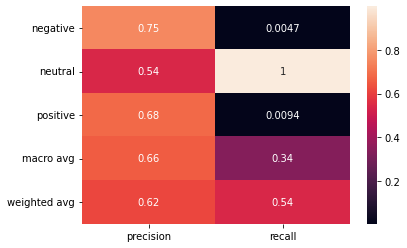

In [ ]:
def make_classification(cr):
    df = pd.DataFrame(cr)
    df.drop('support', inplace = True)
    df.drop(['accuracy'], axis = 1, inplace = True)
    return sns.heatmap(df.iloc[:-1, :].T, annot=True)
cr = classification_report(df['Sentiment'], df['NLTK Sentiment'], output_dict = True)
make_classification(cr);

The VADER model has an accuracy of 54% on our trainign set. This is not the best, but still solid seeing that this is a multi-label classification task (so a model that randomly predicts Positive, Negative, or Netural will have a 33% accuracy). In addition, the chart above shows the precision and recall for our model (for each class individually and the macro/weighted averages as well). Still, there are some interesting insights we can gain from the performance of this model by looking at a confusion matrix.

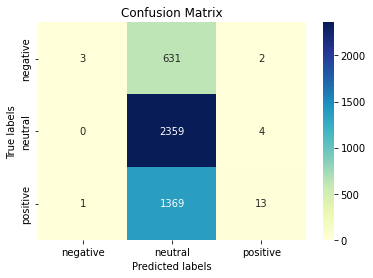

In [ ]:
# Using seaborn to plot confusion matrix for 3 labels
cm = confusion_matrix(list(df["Sentiment"]), list(df["NLTK Sentiment"]))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="YlGnBu"); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']); ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive']);



Based on the confusion matrix, it can be examined that an overwhelming amount of our model's predictions are in the neutral class. To put it simply, the VADER model doesn't see much positive/negative sentiment from each of the sentences. A reason for this could be the fact that the VADER model was not trained on data similar to the provided dataset. 

In a 3-label classification task, a model that outputs the same class 99% of the time, with a balanced dataset, should have an accuracy around 33%. Yet the fact that this dataset is so imbalanced (about 50% neutral), in favoring neutral predictions, this model performs pretty well. Still, we will keep an eye on this model's performance and move on to some more complicated/complex models

### TFIDF + Simple Classification

Next, we decided to test out different simple classification models with our text data transformed by TF-IDF.

TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a  measure that evaluates how relevant each word is to a sentence in a collection of sentences (or documents). It is done by multiplying how many times a word appears in a document by the inverse document frequency of the word over all the documents.

In our use case, TFIDF is extremely useful in that it can transform our data, in the form of text, into a numerical vector that our machines can interpret. Using these vectors with the new text vectorization, we can apply different classification models into algorithms like Logistic Regression, Naive Bayes and Support Vector Machines to achieve great model performance and successfully determine the sentiment of a given sentence.

In [ ]:
# Lemmatizing, removing stop wrods, and removing punctuation (data cleaning)
# Creating 

lemmatizer = WordNetLemmatizer()
def removeStopTotal(sentence):
    words = []
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for word in sentence.split():
        if word.lower() not in stopwords.words('english') and word.lower() not in punc:
            lemon = lemmatizer.lemmatize(word.lower())
            words.append(lemon)
    return ' '.join(words)
df["Sentence No Stop"] = df["Sentence"].apply(removeStopTotal)
df.head()

,Sentence,Sentiment,NLTK Sentiment,Sentence No Stop
0,According to the Finnish-Russian Chamber of Co...,neutral,neutral,according finnish-russian chamber commerce maj...
1,The Swedish buyout firm has sold its remaining...,neutral,neutral,swedish buyout firm sold remaining 22.4 percen...
2,$SPY wouldn't be surprised to see a green close,positive,neutral,$spy surprised see green close
3,Shell's $70 Billion BG Deal Meets Shareholder ...,negative,neutral,shell's $70 billion bg deal meet shareholder s...
4,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative,neutral,ssh communication security corp stock exchange...


In [ ]:
# Creating a simple train test split (75/25)
X_train,X_test,y_train, y_test = train_test_split(df["Sentence No Stop"], df["Sentiment"], test_size=0.25)


In [ ]:
# Vectorizing our new column (without stop words)

vectorizer = TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

##### Model Selection

We decided to select 5 popular data classification models and test each model on the data to see which performs better. Some of our models are simpler like Logistic Regression, while others are more complex like Radial Support Vector Classifiers.

Our idea is to loop run each model on our data and select the model with the best accuracy as our top model. With that model, we can look deeper (confusion matrix) and even look into hyparameter tuning using grid search with 5 fold validation. 

In [ ]:
# Initializing each of our models

models = [LogisticRegression(), MultinomialNB(), KNeighborsClassifier(), DecisionTreeClassifier(), LinearSVC()]


In [ ]:
# Looping through, fitting each model on TFIDF train data, creating predictions, and analyzing accuracy

model_acc = {}
for clf in models:
    string_mod = str(clf)
    clf.fit(tf_x_train,y_train)
    y_test_pred = clf.predict(tf_x_test)
    a = accuracy_score(y_test, y_test_pred)
    model_acc[string_mod] = a
print(model_acc)

{'LogisticRegression()': 0.6806569343065694, 'MultinomialNB()': 0.6596715328467153, 'KNeighborsClassifier()': 0.593978102189781, 'DecisionTreeClassifier()': 0.5894160583941606, 'LinearSVC()': 0.6678832116788321}


From this, it appears that logistic regression has the best accuracy at around 68%. Multinomial Naive Bayes and the SVM are also very close at around 65-66%, and KNeighbors Classifier and Decision Tree Classifier are the worst performing at around 59%. Since logistic regression performed the best, we can take a deeper look at it:

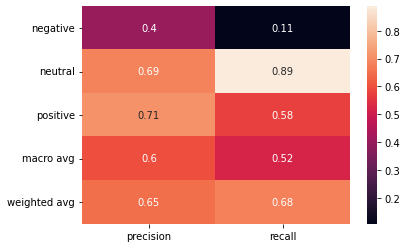

In [ ]:
clf = LogisticRegression()
clf.fit(tf_x_train,y_train)
y_test_pred = clf.predict(tf_x_test)
cr = classification_report(y_test, y_test_pred, output_dict = True)
make_classification(cr);

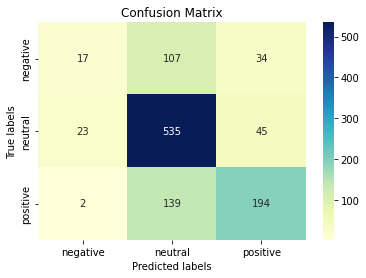

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="YlGnBu"); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']); ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive']);

Similar to the NLTK, the logistic regression model is hweavily favoring the neutral class in its predictions. This is unsurprising because we already know there is a signficant class imbalance, so it makes sense that the model will be predicting neutral more often.

From here, we could take our top 3 models (Logistic Regression, Multinomial Naive Bayes, and SVM) and hyperparameter tune each one to see if we can increase our accuracy. But before we do this, we want to try out an even more complex model using Deep Learning to see if it is necessary to hyperparameter tune these simpler models in the first place.

### roBERTa base for Sentiment Analysis

roBERTa base for sentiment analysis is a model from HuggingFace that is "trained on ~58M tweets and finetuned for sentiment analysis with the TweetEval benchmark" (https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment). This model is extremely interesting for our use case because it is already pretrained on tweets, which closely resembles the style of the data for this project. Similar to VADER, since this is a pretrained model, we will use the whole of the training dataset as a benchmark for model performance.

In [ ]:
# Initializing model and requests

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [ ]:
def roberta_text_sentiment(text):
    """
    Given a tweet, what is the sentiment?
    """
    
    def preprocess(text):
        new_text = []
        for t in text.split(" "):
            t = '@user' if t.startswith('@') and len(t) > 1 else t
            t = 'http' if t.startswith('http') else t
            new_text.append(t)
        return " ".join(new_text)
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    dictionary = {}
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        dictionary[l] = np.round(float(s), 3)
    return dictionary

roberta_text_sentiment(input())

WE LOVE DATAHACKS :)


{'negative': 0.002, 'neutral': 0.023, 'positive': 0.975}

In [ ]:
df_new = pd.read_csv("advanced_trainset.csv")

In [ ]:
# Applying our reoberta text sentiment to each sentence and creating an output column with predicted results
roberta_scores = []
for i in list(df_new["Sentence"]):
    roberta_scores.append(max(roberta_text_sentiment(i), key=roberta_text_sentiment(i).get))
df_new["Roberta Sentiment"] = roberta_scores


With an accuracy of roughly 75%, the roBERTA based sentiment model clearly outperforms the rest and will be our final model to use on the test dataset. This model also favors the neutral class as seen above but this is again intuitive because of the class imbalance as seen in other models. Again, we think this model is extremely powerful because it is trained on Tweets which we would argue closely resembles the training data. We are extremely happy with the results as 75% is a great accuracy with regards to the fact that this is a multi-label classification task with a benchmark of 33%.

### Predictions

In [ ]:


# test_df = pd.read_csv("advanced_testset.csv")
# roberta_test_scores = []
# for i in list(test_df["Sentence"]):
#     roberta_test_scores.append(max(roberta_text_sentiment(i), key=roberta_text_sentiment(i).get))
# output = pd.DataFrame()
# output["Sentiment"] = roberta_test_scores
# # output.to_csv("output.csv")